# 4 Similarity Graphs

In [2]:
import gensim
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from gensim import models
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
plt.style.use('seaborn-whitegrid')

## 4.1 Category Similarity Graph

In [4]:
df = pd.read_csv('dataframe_raw.temp.csv').drop(columns = ['Unnamed: 0'])
df['headline'] = df['headline'].str.replace('[^a-zA-Z ]', '')
df['headline'] = df['headline'].str.lower()
popular_words = pd.read_csv('popular_words.temp.csv').drop(columns = ['Unnamed: 0'])

In [5]:
category_models = {}
for category in set(df.category):
    tokens = popular_words[popular_words['category'] == category].corpus_specific_words
    category_models[category] = Word2Vec(tokens, size=100)

In [6]:
all_categories = popular_words.category.tolist()
category_tuples = list(itertools.product(all_categories, all_categories))

category_tuples_nonunique = list(
    set([frozenset(tup) for tup in category_tuples if tup[0] != tup[1]])
)

category_tuples_unique = [tuple(frozen) for frozen in category_tuples_nonunique]

In [7]:
category_words = dict([
    (popular_words.loc[i].category, popular_words.corpus_specific_words[i][2:-3].split("', '")) \
    for i in range(popular_words.shape[0])
])

min_len = min([len(l) for l in category_words.values()])

In [8]:
category_similarities_list = []

for tup in category_tuples_unique:
    words_zero = set(category_words[tup[0]][:100])
    words_one = set(category_words[tup[1]][:100])
    intersection_count = len(list(words_zero.intersection(words_one)))
    category_similarities_list.append([tup, intersection_count])

In [9]:
similarities = [l[1] for l in category_similarities_list]

scaled_category_similarities = [
    (sim - min(similarities)) / (max(similarities) - min(similarities)) for sim in similarities
]

category_similarities_list_sclaed = list(
    zip(category_tuples_unique, scaled_category_similarities)
)

category_similarities_list_sclaed = [
    (tup[0][0], tup[0][1], tup[1]) for tup in category_similarities_list_sclaed
]

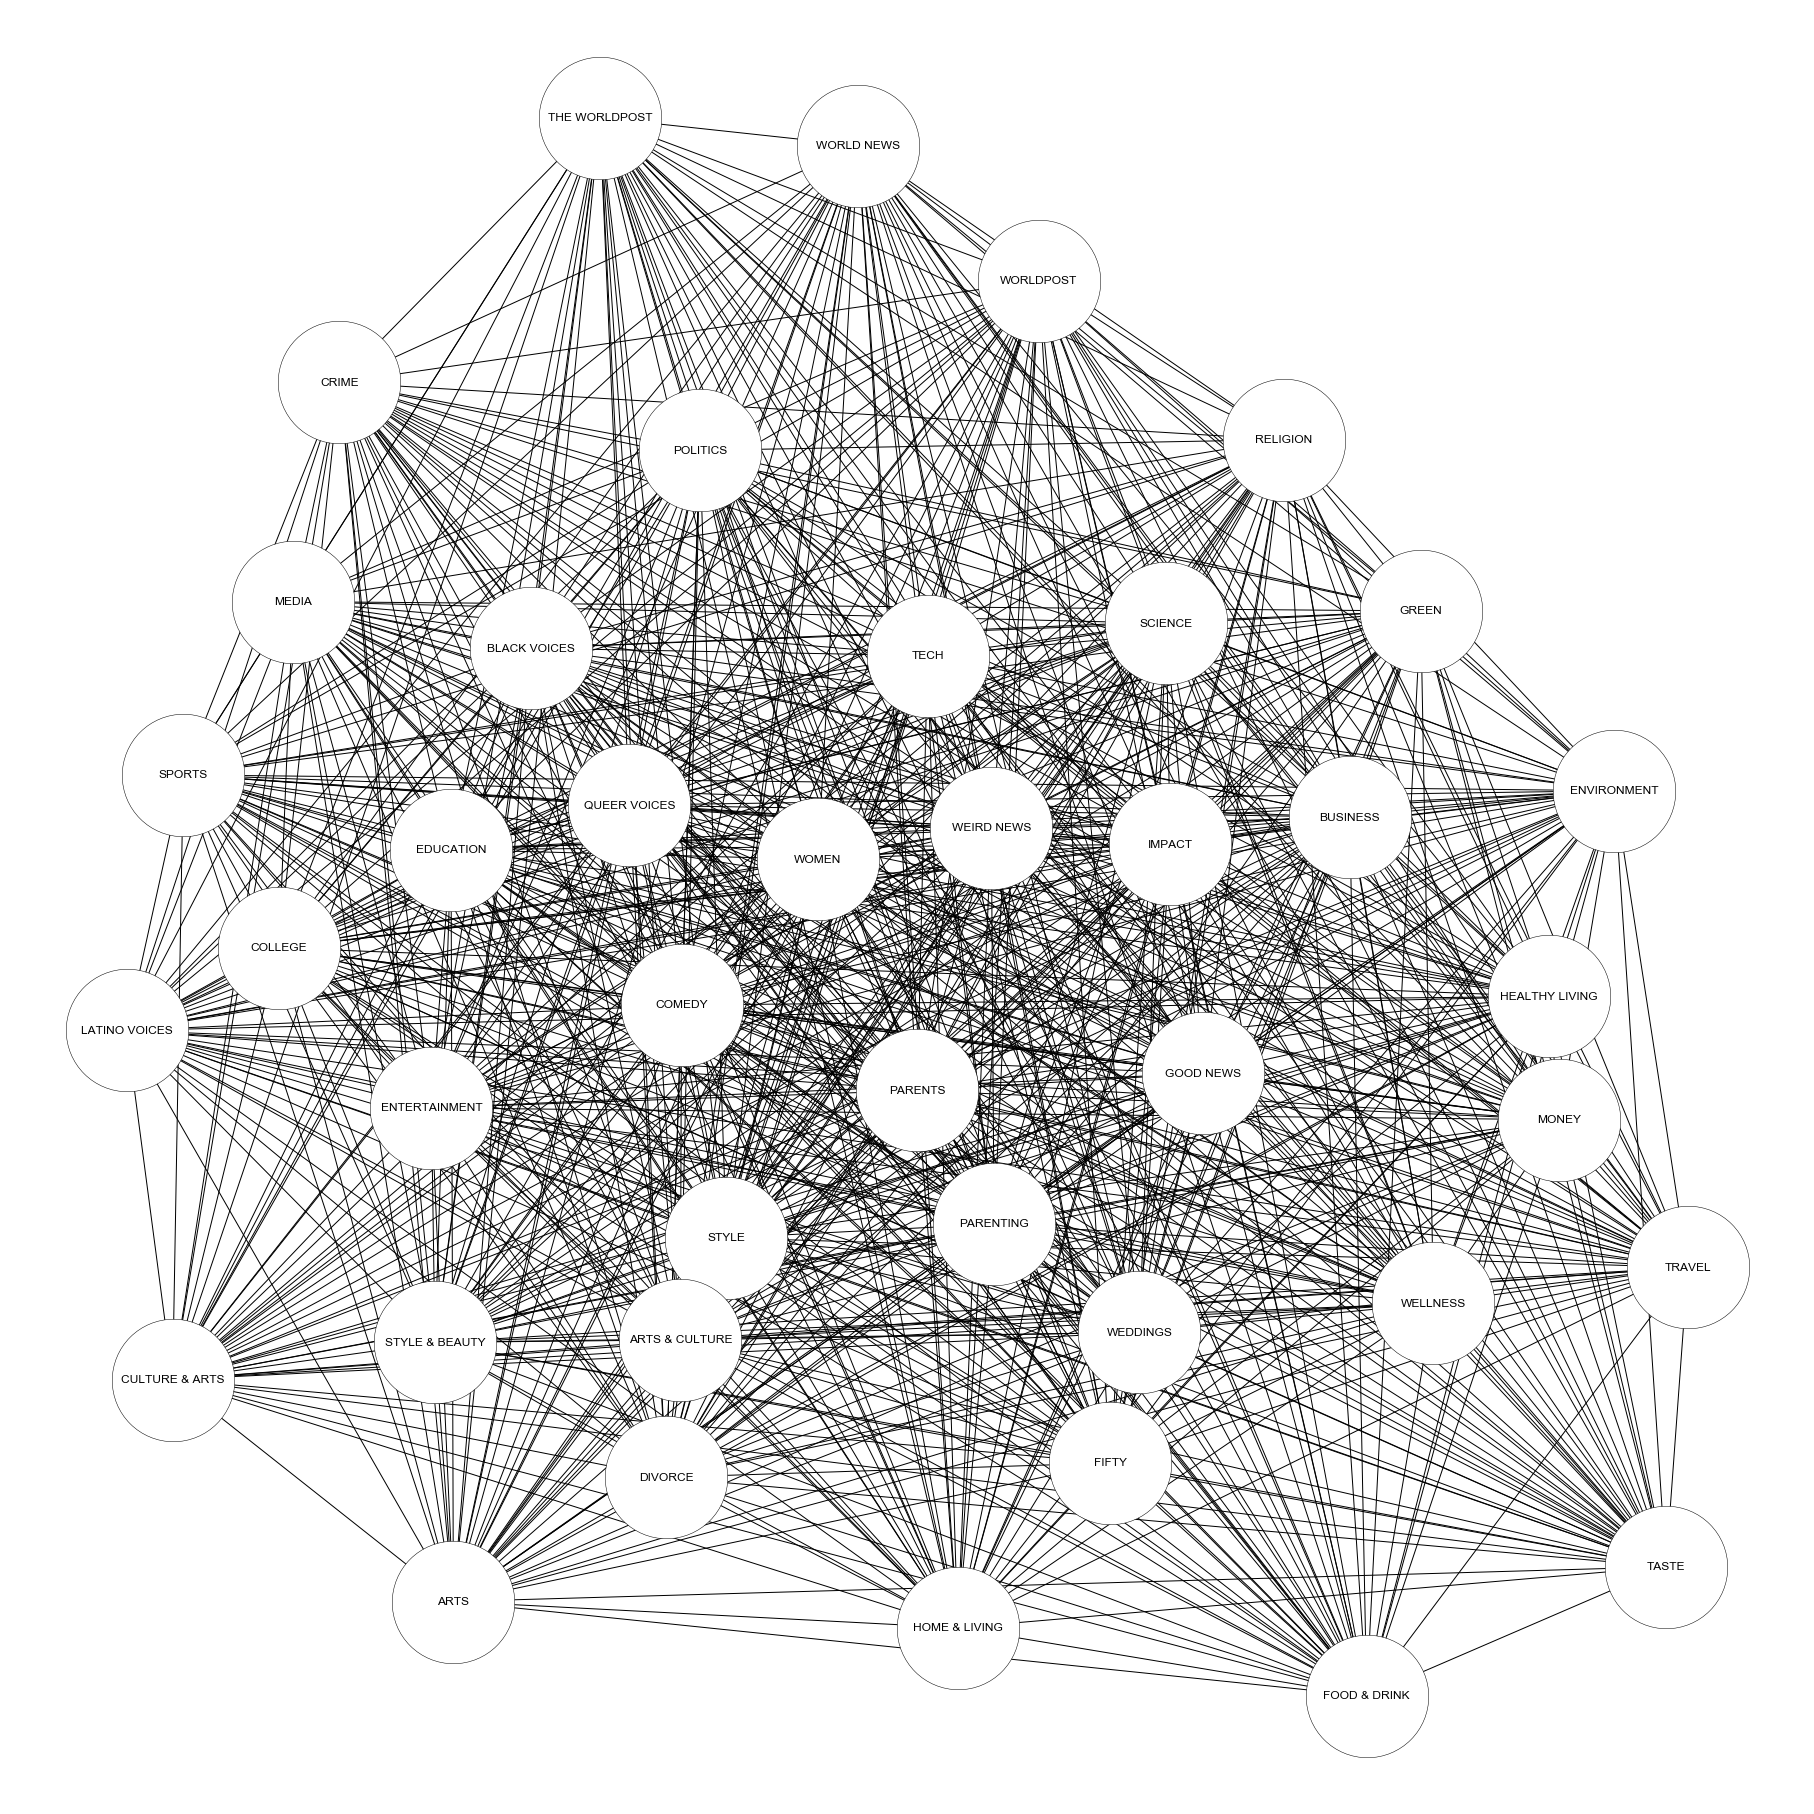

In [10]:
category_similarity_graph = nx.Graph()
category_similarity_graph.add_nodes_from(all_categories)
category_similarity_graph.add_weighted_edges_from(category_similarities_list_sclaed)

plt.figure(3,figsize=(25, 25)) 
nx.draw(
    category_similarity_graph,
    with_labels = True,
    node_size = 15000,
    linewidths = 0.5,
    node_color = 'white'
)
plt.gca().collections[0].set_edgecolor('black') 
plt.show();

In [11]:
category_similarities_sorted = sorted(category_similarities_list_sclaed, key=lambda tup: tup[2])
print('The 10 most similar categories are:')
category_similarities_sorted[-10:][::-1]

The 10 most similar categories are:


[('FOOD & DRINK', 'TASTE', 1.0),
 ('PARENTS', 'PARENTING', 0.9705882352941176),
 ('THE WORLDPOST', 'WORLDPOST', 0.8235294117647058),
 ('WELLNESS', 'HEALTHY LIVING', 0.7941176470588235),
 ('THE WORLDPOST', 'WORLD NEWS', 0.7647058823529411),
 ('ARTS', 'CULTURE & ARTS', 0.7352941176470589),
 ('GREEN', 'ENVIRONMENT', 0.7352941176470589),
 ('STYLE & BEAUTY', 'STYLE', 0.7352941176470589),
 ('WORLDPOST', 'WORLD NEWS', 0.6617647058823529),
 ('PARENTING', 'FIFTY', 0.4852941176470588)]

In [12]:
print('The 10 most dissimilar categories are:')
category_similarities_sorted[:10]

The 10 most dissimilar categories are:


[('PARENTING', 'WORLD NEWS', 0.0),
 ('TASTE', 'CRIME', 0.0),
 ('FOOD & DRINK', 'WORLD NEWS', 0.0),
 ('THE WORLDPOST', 'ARTS', 0.0),
 ('LATINO VOICES', 'TASTE', 0.014705882352941176),
 ('WORLD NEWS', 'HOME & LIVING', 0.014705882352941176),
 ('THE WORLDPOST', 'DIVORCE', 0.014705882352941176),
 ('WELLNESS', 'THE WORLDPOST', 0.014705882352941176),
 ('FOOD & DRINK', 'POLITICS', 0.014705882352941176),
 ('TASTE', 'WORLD NEWS', 0.014705882352941176)]

## 4.2 Word Similarity Graph

In [13]:
headlines_model = gensim.models.Word2Vec.load('headlines_model.model')

words_share_without_common_words = []
with open("words_share_without_common_words.temp.txt", "r") as file:
    for line in file: words_share_without_common_words.append(line)

In [14]:
most_common_words = [
    word.split(',')[0].split("'")[1] for word in words_share_without_common_words[:60]
]

In [15]:
bad_words = ['(PHOTOS)', '(VIDEO)', '(PHOTO)', 's"', 's"', 'The', '7', 'The"', 'Video',
             'Shows', 'Calls','Gets', 'Watch', 'Finds', 'Shooting', '8', 'Photos',
             'Wants', 't"', '\\\\', '9', 'Takes', 't"', "-", 'Star']

most_common_words_cleaned = [word for word in most_common_words if word not in bad_words]

In [16]:
words_list = list(itertools.product(most_common_words_cleaned, most_common_words_cleaned))
words_list_nonunique = list(set([frozenset(tup) for tup in words_list if tup[0] != tup[1]]))
words_list_unique = [tuple(frozen) for frozen in words_list_nonunique]

In [17]:
word_similarities_list = []

for tup in words_list_unique:
    word_similarities_list.append(
        [tup, headlines_model.wv.similarity(tup[0].lower(), tup[1].lower())]
    )

word_similarities_list_formatted = [
    (tup[0][0], tup[0][1], tup[1]) for tup in word_similarities_list
]

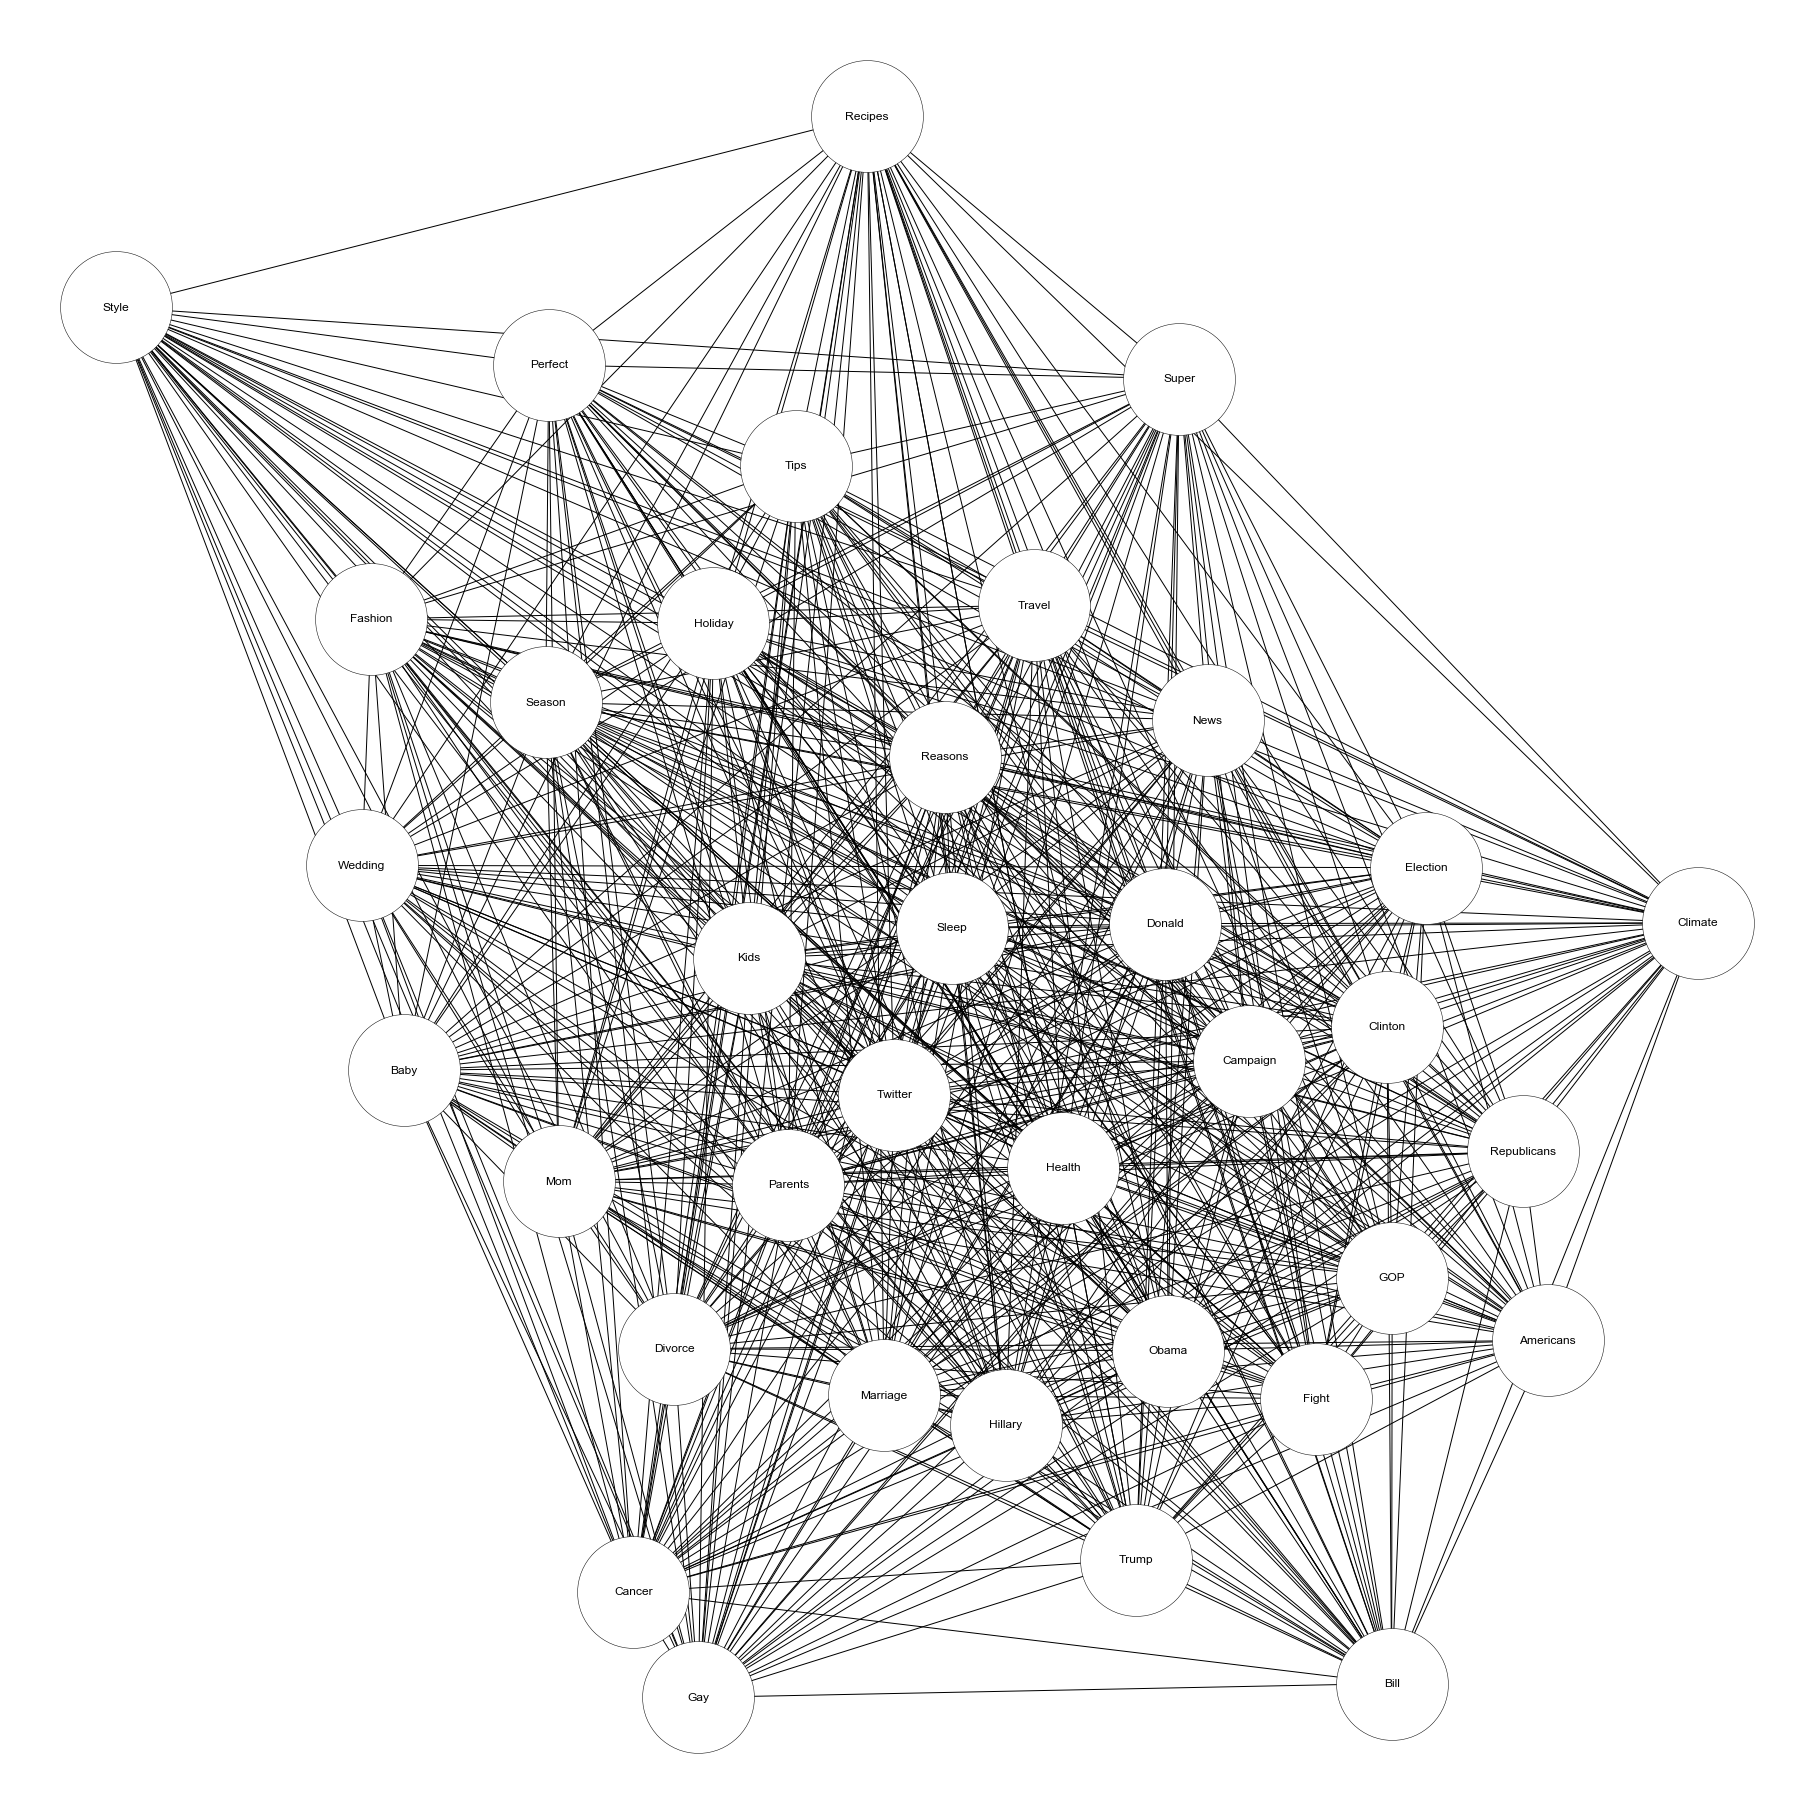

In [18]:
word_similarity_graph = nx.Graph()
word_similarity_graph.add_nodes_from(most_common_words_cleaned)
word_similarity_graph.add_weighted_edges_from(word_similarities_list_formatted)

plt.figure(3,figsize=(25, 25)) 
nx.draw(word_similarity_graph, with_labels = True, node_size = 12500, linewidths = 0.5, node_color = 'white')
plt.gca().collections[0].set_edgecolor('black') 
plt.show();